
**Initialization**

In [20]:
import seaborn as sns
import os
import networkx as nx
from pprint import pprint
import pandas as pd
import numpy as np
import random
import math as m
import glob
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
from grave import plot_network
basedir = '../results'
from tqdm.notebook import tqdm
def giant_component(g: nx.Graph) -> nx.Graph:
    return nx.subgraph(g, max(nx.connected_components(g), key=len))

from scipy.stats import t
def ci(series):
    return series.sem()*t.ppf((1 + 0.95) / 2., len(series)-1)

def to_csv_comment(df, path):
    with open(path, 'w') as fr:
        fr.write('#'+df.to_csv())

/tmp/ipykernel_75219/2691174795.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


**Experimental Variables**

In [21]:
#CapEx costs
capex_costs = {
    'gateway_deploy': 10000, #cost to deploy trellis + works + permits
    'gateway_router': 5000, # 
    'fiber_deploy': 6000, # per km (aerial)
    'relay_router': 500, # 
    'relay_deploy':  1000, # cost for trellis +  works 
    'leaf_deploy': 300, #cost for roof installation
    'leaf_radio': 100, #cost of LHG XL5 ac
    'mp_radio': 200 # cost of mANTBox 19
}

#OpEx costs
opex_costs = {
    'bw': 1680, #Euros per year for 1Gbps  [Cerdà 2020]
    'transport_10': 31200, # yearly price for transport of 10Gbps [xarxaoberta.cat]
    'transport_100': 55200,  # yearly price for transport of 100Gbps [xarxaoberta.cat]
    'planned_maintenance': 50, #euros per hour to repair
    'unplanned_maintenance': 200 #euros per hour to repair
}

#Reliability values
mttf = {
    'router': 2e5, #hours [verbrugge 2006] 22y
    'radio': 1e5, #hours [mikrotik datasheet]  11yrs
}

mttr = {
    'router': 2, #hours [verbrugge 2006]
    'radio': 4, #hours [assumed]
}

#802.11ac technological values
speed_table = [(-72, 400),    #MCS Rx table derived by Mikrotik antbox19 datasheet (some values have been interpolated)
               (-75,360),
               (-77,300),
               (-83,270),
               (-86,240),
               (-90,180),
               (-92,120),
               (-94,90),
               (-95,60),
               (-96,30)] 

pt = 30 # (dBm) Maximum EIRP According to Italian regulations (1W)
gr_m = 19 # (dBi) received gain for mANTBox 19
gr_d = 27 # (dBi) received gain for LHG XL5

max_bx = 360   #max ch capacity at mcs8
contention_ratio = 50
mpant_bw = 120 #beamwidth of the mANTbox 19
mgb =  max_bx/contention_ratio
mchan = max_bx/contention_ratio


**Read Data**

In [24]:
##Read all the graphs
import re
# re.split('; |, |\*|\n',a)
graphs = []
#
files = glob.glob(f'{basedir}/*/*.wireless.graphml.gz')

for f in files:
    w_g = nx.read_graphml(f)
    f_g = nx.read_graphml(f.replace('wireless', 'fiber'))
    n_cust = sum([w_g.nodes[n]['subscriptions'] for n in w_g.nodes() if w_g.degree()[n] > 0])
    graphs.append((f.replace(basedir, ''),w_g,f_g,n_cust))


**Simple Metrics**

In [29]:
def average_path_length(graph: nx.Graph):
    gws = [n for n in graph if 'type' in graph.nodes[n] and graph.nodes[n]['type'] == 'gateway']
    print(graph.nodes(data=True))
    plenghts = nx.multi_source_dijkstra_path_length(graph, gws)
    lengths = np.array(list(plenghts.values()))

    return lengths.mean(), lengths.max()

data = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    measures['nodes'] = len(w_g)
    measures['n_gw'] = n_gw
    measures['subscriptions'] = n_subs
    measures['edges'] = len(w_g.edges())
    measures['avg_pathl'], measures['max_pathl'] = average_path_length(w_g)
    measures['area'] = area
    measures['ratio'] = int(ratio)
    measures['gateways'] = len([n for n,att in w_g.nodes(data=True) if att.get('type')=='gateway'])
    measures['leaves'] = len([n for n in w_g.nodes() if w_g.degree()[n]==1])
    measures['relays'] = len([n for n in w_g.nodes() if w_g.degree()[n]>1]) - measures['gateways']
    measures['relays_ratio'] =  measures['relays']/n_subs
    unc = sum([d['subscriptions'] for n, d in w_g.nodes(data=True) if w_g.degree()[n] == 0])
    all_sub = sum([d['subscriptions'] for n, d in w_g.nodes(data=True)])
    measures['unc'] = unc
    measures['unconnected'] = unc/all_sub
    measures['cluster_size'] = int(cluster_size)
    measures['time'] = time
    measures['seed'] = random_seed
    data.append(measures)
        
df = pd.DataFrame(data)


[('727182337', {'x': 1709188, 'id': 727182337, 'y': 4737096, 'subscriptions': 1}), ('727181698', {'x': 1708304, 'id': 727181698, 'y': 4733744, 'subscriptions': 1}), ('727181573', {'x': 1708418, 'id': 727181573, 'y': 4733502, 'subscriptions': 1}), ('727181833', {'x': 1708216, 'id': 727181833, 'y': 4733971, 'subscriptions': 1}), ('705565194', {'x': 1708463, 'id': 705565194, 'y': 4733470, 'subscriptions': 1}), ('727182346', {'x': 1709214, 'id': 727182346, 'y': 4737087, 'subscriptions': 1}), ('727181705', {'x': 1708329, 'id': 727181705, 'y': 4733738, 'subscriptions': 1}), ('705565197', {'x': 1708442, 'id': 705565197, 'y': 4733491, 'subscriptions': 2}), ('727182222', {'x': 1709408, 'id': 727182222, 'y': 4736876, 'subscriptions': 1}), ('727182228', {'x': 1709349, 'id': 727182228, 'y': 4736907, 'subscriptions': 1}), ('727181717', {'x': 1708382, 'id': 727181717, 'y': 4733777, 'subscriptions': 1}), ('727181718', {'x': 1708304, 'id': 727181718, 'y': 4733773, 'subscriptions': 1}), ('727181721', {

ValueError: sources must not be empty

In [ ]:
df.groupby(['cluster_size','ratio', 'n_gw' ]).mean()

nodes  subscriptions       edges  avg_pathl  \
cluster_size ratio n_gw                                                     
50           25    1     270.812500     313.937500  242.900000   1.507058   
                   2     270.812500     313.387500  235.525000   1.317241   
             50    1     458.025000     640.550000  418.562500   1.406930   
                   2     458.025000     638.675000  404.312500   1.249479   
             100   1     713.150000    1296.412500  653.000000   1.350674   
                   2     713.150000    1288.087500  625.250000   1.191715   
100          25    1     296.066667     361.355556  266.188889   1.685176   
                   2     296.066667     361.177778  261.744444   1.437448   
             50    1     497.544444     748.033333  464.822222   1.563820   
                   2     497.544444     747.500000  456.377778   1.408839   
             100   1     730.452381    1384.452381  681.607143   1.505358   
                   2     725.963855    1359.000000  662.120482   1.359359   
200          25    1     296.955556     373.211111  277.366667   2.034467   
                   2     296.955556     373.211111  275.033333   1.683003   
             50    1     494.400000     738.422222  456.133333   1.798762   
                   2     494.400000     738.400000  451.688889   1.569340   
             100   1     760.311111    1508.733333  718.033333   1.652124   
                   2     760.311111    1508.411111  709.588889   1.502925   

                         max_pathl   gateways      leaves      relays  \
cluster_size ratio n_gw                                                 
50           25    1      4.387500   7.375000  184.775000   58.125000   
                   2      4.000000  14.750000  184.762500   50.412500   
             50    1      4.350000  14.250000  324.625000   93.937500   
                   2      3.862500  28.500000  324.275000   79.050000   
             100   1      4.375000  27.750000  515.437500  137.562500   
                   2      3.950000  55.500000  511.775000  110.937500   
100          25    1      4.933333   4.444444  197.388889   68.800000   
                   2      4.100000   8.888889  200.788889   60.855556   
             50    1      4.877778   8.444444  353.600000  111.222222   
                   2      4.322222  16.888889  355.200000  100.966667   
             100   1      4.869048  15.095238  525.440476  156.166667   
                   2      4.337349  29.759036  520.590361  140.903614   
200          25    1      5.366667   2.333333  204.433333   72.933333   
                   2      4.711111   4.666667  207.033333   68.000000   
             50    1      5.566667   4.444444  340.788889  115.344444   
                   2      4.777778   8.888889  343.477778  108.188889   
             100   1      5.444444   8.444444  545.322222  172.711111   
                   2      4.833333  16.888889  546.788889  162.711111   

                         relays_ratio        unc  unconnected  
cluster_size ratio n_gw                                        
50           25    1         0.182514  25.687500     0.095338  
                   2         0.159287  26.237500     0.096966  
             50    1         0.145641  39.325000     0.075987  
                   2         0.122453  41.200000     0.078488  
             100   1         0.105442  63.962500     0.055808  
                   2         0.085388  72.287500     0.060711  
100          25    1         0.196798  32.088889     0.136445  
                   2         0.173394  32.266667     0.136908  
             50    1         0.150721  39.522222     0.071932  
                   2         0.140762  40.055556     0.072645  
             100   1         0.112916  68.238095     0.064198  
                   2         0.104906  71.445783     0.066579  
200          25    1         0.201223  20.233333     0.082644  
                   2         0.189675  20.233333     0.082644  
    

**CapEx**

In [ ]:
def calc_cost_fiber(g):
    return sum([d['length'] for s,t,d in g.edges(data=True)])*1e-3*capex_costs['fiber_deploy']

def phi(g, n):
    #Find the size of the occupied beam and see how many antennas are needed to cover it.
    thisnode = g.nodes[n]
    beams = []
    for neigh in g[n]:
        thisneigh = g.nodes[neigh]
        beam = m.degrees(m.atan2(thisneigh['x'] - thisnode['x'], thisneigh['y']-thisnode['y'])) % 360
        beams.append(beam)
    beams.sort()
    try:
        beams.append(beams[0])
    except:
        print(g[n])
    beams = np.array(beams)
    
    diff = (beams[1:] - beams[:-1] -0.0001) % 360
    width = 360 - diff.max()    
    return width

def calc_antennas(g, n, gw):
    phi_v = m.ceil(phi(g, n)/mpant_bw)
    n_paths = sum([n['paths'] for n in g[n].values()])
    if not gw:
        #Relay nodes needs double of the BW
        k=2
    else: 
        k=1
    d_v = m.ceil(n_paths*k/contention_ratio)
    return max(phi_v, d_v)

    

def calc_cost_wireless(g) -> list[float]:
    for e in g.edges():
        g.edges[e]['paths'] = 0
    
    ## For each edge where a SP pass accumulate a value
    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']
    paths = nx.multi_source_dijkstra_path(g, gws, weight='dist')
    for k,path in paths.items():
        n_subs = g.nodes(data=True)[k]['subscriptions']
        for i in range(len(path)-1):
            g.edges[path[i], path[i+1]]['paths'] += n_subs
                 
    ## Multiplicate the value by the BW needed for each node
    ## Calculate the cost of each edge
    for e in g.edges():
        if(g.edges[e]['paths'] == 0):
            ## For redundancy link assume a single path
            g.edges[e]['paths'] = 1
            g.edges[e]['redundant'] = 1
        else:
            g.edges[e]['redundant'] = 0
        g.edges[e]['bw'] = mgb * g.edges[e]['paths']

    for n in g.nodes():
        #If it's unconnected it does not cost
        if nx.degree(g)[n] == 0:
            g.nodes[n]['router_cost'] = 0
            g.nodes[n]['deploy'] = 0
            g.nodes[n]['fiber_cost'] = 0
            g.nodes[n]['radio_cost'] = 0
            continue
        #If it's a GW
        if g.nodes[n].get('type') == 'gateway':
            g.nodes[n]['router_cost'] = capex_costs['gateway_router'] 
            #loc = (g.nodes[n]['x'], g.nodes[n]['y'])
            #g.nodes[n]['fiber_cost' ] = capex_costs['fiber_deploy']*road_distance(fiber_points[area], loc)
            g.nodes[n]['deploy'] = capex_costs['gateway_deploy']
            g.nodes[n]['n_ant'] =  calc_antennas(g, n, True)
            #print(g.nodes[n]['n_ant'])
            g.nodes[n]['radio_cost'] = capex_costs['mp_radio'] * g.nodes[n]['n_ant']
        else:
            g.nodes[n]['fiber_cost' ] = 0
            if g.degree()[n] == 1:
                #leaf node, no router
                g.nodes[n]['radio_cost'] = capex_costs['leaf_radio']
                g.nodes[n]['deploy'] = capex_costs['leaf_deploy']
                g.nodes[n]['router_cost'] = 0
                g.nodes[n]['n_ant'] = 1
            else:
                #relay node
                g.nodes[n]['n_ant'] = calc_antennas(g, n, False) 
                g.nodes[n]['radio_cost'] = capex_costs['mp_radio'] * g.nodes[n]['n_ant']
                g.nodes[n]['deploy'] = capex_costs['relay_deploy']
                g.nodes[n]['router_cost'] = capex_costs['relay_router']
        
        
    router_cost = sum([g.nodes[n]['router_cost'] for n in g.nodes()])
    deploy = sum([g.nodes[n]['deploy'] for n in g.nodes()])
    radio_cost = sum([g.nodes[n]['radio_cost'] for n in g.nodes()])

    return [router_cost, deploy, radio_cost]
  

In [ ]:
data = []
data_summed = []
   
for (f,w_g,f_g, n_subs) in graphs:
    graph = w_g.copy()
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    costs = calc_cost_wireless(w_g)
    costs.append(calc_cost_fiber(f_g))
   
    type_costs = ['router_cost', 'deploy', 'radio_cost', 'fiber_cost']
    total_cost = sum(costs)
    data_summed.append({'capex': total_cost/n_subs/5/12,
                        'area': area, 
                        'cluster_size': cluster_size,
                        'ratio':ratio,
                        'n_gw': n_gw})

    for i in range(4):
        measures = {}
        measures['cost'] = costs[i]
        measures['cost_customer'] = costs[i]/n_subs
        measures['5ymontlycostcustomer'] = costs[i]/n_subs/5/12
        measures['type_cost'] = type_costs[i]
        measures['area'] = area
        measures['ratio'] = ratio
        measures['cluster_size'] = cluster_size
        measures['time'] = time
        measures['seed'] = random_seed
        measures['n_gw'] = n_gw

        data.append(measures)
        
edf = pd.DataFrame(data)
sedf = pd.DataFrame(data_summed)

**OpEx**

In [ ]:
def calc_opex_fiber_network(g):
    #Fiber opex
    total_bw = sum([d['subscriptions'] for n,d in g.nodes(data=True)])*mgb/1000 #Gbps of mgb
    fiber_transit = m.ceil(total_bw)*opex_costs['bw']
    if total_bw < 10:
        fiber_trasport = opex_costs['transport_10']
    elif total_bw < 100:
        fiber_trasport = opex_costs['transport_100']
    else:
        raise ValueError("Can't relay more than 100G")
    return fiber_transit, fiber_trasport

def calc_opex_maintenance(g, kind):
    #Maintenance opex
    relays = [n for n in g if  g.degree[n] > 1]
    leafs = [n for n in g if  g.degree[n] == 1]
    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']
    p_leaf = len(leafs)/len(g)
    p_relay = len(relays)/len(g)
    p_radio_failure = (364*24)/mttf['radio']
    p_router_failure = (364*24)/mttf['router']

    n_tot_ants = sum([g.nodes[n]['n_ant'] for n in relays])
        
    gw_maintenance = p_router_failure * len(gws) * (mttr['router'] * opex_costs[kind] + capex_costs['gateway_router'])
    router_maintenance = p_router_failure  * len(relays) * (mttr['router'] * opex_costs[kind] + capex_costs['relay_router'])
    leafs_maintenance = p_leaf * p_radio_failure * len(leafs) * (mttr['radio'] * opex_costs['planned_maintenance'] + capex_costs['leaf_radio'])
    relays_maintenance = p_relay * p_radio_failure * n_tot_ants * (mttr['radio'] * opex_costs[kind] + capex_costs['mp_radio'])
    return gw_maintenance + router_maintenance + leafs_maintenance + relays_maintenance
    

In [ ]:
data = []
data_summed = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    
    fiber_cost, transport_cost = calc_opex_fiber_network(w_g)
    cost_types = ['fiber', 'planed_maintenance', 'unplanned_maintenance']
    planned_maint = calc_opex_maintenance(w_g, 'planned_maintenance')
    unplanned_maint = calc_opex_maintenance(w_g, 'unplanned_maintenance')

    data.append({'fiber_cost': fiber_cost/n_subs/12,
                 'transport_cost': transport_cost/n_subs/12,
                 'unplanned_cost':  unplanned_maint/n_subs/12,
                 'area': area, 
                 'cluster_size': cluster_size,
                 'ratio':ratio,
                 'n_gw': n_gw})    

    data_summed.append({'cost': planned_maint+fiber_cost, 
                        'cost_customer': (planned_maint+fiber_cost)/n_subs, #Cost per customer per mbps
                        'cost_customer_monthly': (planned_maint+fiber_cost)/n_subs/12,
                        'area': area, 
                        'maintennace': 'planned',
                        'cluster_size': cluster_size,
                        'ratio':ratio,
                        'n_gw': n_gw})

opdf = pd.DataFrame(data)
sopdf = pd.DataFrame(data_summed)

**Offered Bandwidth**

In [ ]:
def calc_speed(g, src, dst):
    d = g[src][dst]['dist']
    pl = 20*m.log10(4*m.pi*d/0.0599585) #5ghz
    if g.degree()[dst] == 1: # leaf
        pr = pt + gr_d - pl
    else: #relay
        pr = pt + gr_m - pl
    
    for i in range(len(speed_table)):
        if pr>speed_table[i][0]:
            return speed_table[i][1]
    return 0


def calc_maxbw(g, p):
    bottleneck = speed_table[0][1] #initalize to maximum value (400mbps)
    for i in range(len(p)-1):
        speed = calc_speed(g, p[i], p[i+1])
        if speed<bottleneck:
            bottleneck=speed
    return bottleneck

def calc_minbw(g, p):
    bw_path = [max_bx*g.nodes[n]['n_ant']/sum([n['paths'] for n in g[n].values()]) for n in p]
    pass
    return min(bw_path)
        
def calc_minbw_leo(g, p):
    bw_path = []
    bw_path.append(max_bx*g.nodes[p[0]]['n_ant']/sum([n['paths'] for n in g[p[0]].values()]))
    for i in range(0, len(p)-1):
        speed = calc_speed(g, p[i], p[i+1])
        links = g[p[i]][p[i+1]]['paths']
        bw_path.append(speed/links)
    pass
    return min(bw_path)

def calc_minbw_gab(g, path):
    return min([g.nodes[p]['bottleneck'] for p in path])

        

In [ ]:
mac_efficiency = 0.84

data = []
for g_id, (f,w_g,f_g, n_subs) in enumerate(graphs):
    #print(g_id, len(graphs))
    measures = {}
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    cluster_size = int(cluster_size)
    ratio = int(ratio)

    gws = [n for n in w_g if 'type' in w_g.nodes[n] and w_g.nodes[n]['type'] == 'gateway']
    paths = nx.multi_source_dijkstra_path(w_g, gws, weight='dist')
    speeds = []
    for n in w_g.nodes():
        if w_g.degree()[n]>0:
            caps = []
            n_paths = 0
            for neigh in w_g[n].keys():
                caps.append(calc_speed(w_g, n, neigh))
                n_paths += w_g[n][neigh]['paths']
            w_g.nodes[n]['capacity'] = w_g.nodes[n]['n_ant'] * np.mean(caps)
            w_g.nodes[n]['paths'] = n_paths
            w_g.nodes[n]['bottleneck'] = w_g.nodes[n]['capacity'] / n_paths

    
    for src, p in paths.items():
        if src in gws:
            continue
        #min_bw = calc_minbw(w_g, p)
        min_bw = calc_minbw_gab(w_g, p)
        
        max_bw = calc_maxbw(w_g, p)
        for s in range(w_g.nodes(data=True)[src]['subscriptions']):
            run = {}
            run['area'] = area
            run['cluster_size'] = cluster_size
            run['ratio'] =  ratio
            run['gateways'] = len([n for n,att in w_g.nodes(data=True) if att.get('type')=='gateway'])
            run['n_gw'] = n_gw
            run['node'] = src
            #run['min_bw'] = mac_efficiency*min_bw
            run['max_bw'] = mac_efficiency*max_bw
            run['min_bw'] = mac_efficiency*min_bw
            data.append(run)

bwdf = pd.DataFrame(data)

**Antennas per node**

In [ ]:

data = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    cluster_size = int(cluster_size)
    ratio = int(ratio)

    gws = [n for n in w_g if 'type' in w_g.nodes[n] and w_g.nodes[n]['type'] == 'gateway']
    
    for n in w_g.nodes():
        if w_g.degree()[n] > 0:
            run = {}
            run['area'] = area
            run['cluster_size'] = cluster_size
            run['ratio'] =  ratio
            if n in gws:
                run['type'] = 'gw'
            elif w_g.degree()[n]==1:
                run['type'] = 'leaf'
            else:
                run['type'] = 'relay'
            run['antennae'] =  w_g.nodes[n]['n_ant']
            run['degree'] = w_g.degree()[n]
            run['n_gw'] = n_gw
            data.append(run)
            

df3 = pd.DataFrame(data)

**Gnuplot Graphs**

Fiber deploy over cluster size and customer ratio

In [ ]:
for n_gw in ['1','2']:
    fiber = edf[(edf.type_cost=='fiber_cost') & (edf.n_gw == n_gw)]
    data = fiber.groupby(['ratio', 'cluster_size'])['cost_customer'].agg(['mean', ci])
    data = data.reset_index().pivot('cluster_size', 'ratio',['mean', 'ci'])
    data.columns = ["_".join([a[0], str(a[1])]) for a in data.columns.to_flat_index()]
    to_csv_comment(data, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/fiber_cost_{n_gw}.csv')
#sns.relplot(data=data, x='gateways', y='mean', hue='ratio', kind='line')


Overall cost for cluster = 200 over customer ratio

In [ ]:
for n_gw in ['1','2']:
    print(n_gw)
    costs = opdf[(opdf.cluster_size==200)& (opdf.n_gw == n_gw)].groupby('ratio')[['fiber_cost', 'transport_cost', 'unplanned_cost']].agg(['mean', ci])
    capex = sedf[(sedf.cluster_size==200)& (sedf.n_gw == n_gw)].groupby('ratio')['capex'].agg(['mean', ci])
    costs['capex', 'mean'] = capex['mean']
    costs['capex', 'ci'] = capex['ci']
    costs.columns = ["_".join(a) for a in costs.columns.to_flat_index()]
    costs['recurring'] = costs['fiber_cost_mean'] + costs['transport_cost_mean'] + costs['unplanned_cost_mean']
    costs['sum'] = costs['recurring'] + costs['capex_mean']

    costs.index = costs.index/100
    to_csv_comment(costs, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/costs_{n_gw}.csv')


1
2


Capex customer breaked up

In [ ]:
for n_gw in ['1','2']:
    rat = df[(df.cluster_size == 200) & (df.n_gw == n_gw)].groupby(['ratio'])['relays_ratio'].agg(['mean', ci])
    capex1 = edf[(edf.cluster_size==200) & (edf.n_gw == n_gw)].groupby(['ratio', 'type_cost'])['cost_customer'].agg(['mean', ci])
    capex =  capex1.reset_index().pivot('ratio', 'type_cost',['mean', 'ci'])
    capex.columns = ["_".join(a) for a in capex.columns.to_flat_index()]
    capex['relayratio_mean'] = rat['mean']
    capex['relayratio_ci'] = rat.ci
    capex['sum'] = capex['mean_deploy'] + capex['mean_fiber_cost'] + capex['mean_radio_cost'] + capex['mean_router_cost']

    capex.index = capex.index/100
    to_csv_comment(capex, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/capex_{n_gw}.csv')


Effective bandwidth

In [ ]:
for n_gw in ['1', '2']:

    min_bw = bwdf[bwdf.n_gw == n_gw].groupby(['ratio'])['min_bw'].agg(['mean', ci])
    #min_bw.index = min_bw.index/100
    to_csv_comment(min_bw, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/min_bw_{n_gw}.csv')
#sns.relplot(data=bwdf, x='gateways', y='min_bw', hue='ratio', kind='line')

In [ ]:
for n_gw in ['1', '2']:
    max_bw = bwdf[(bwdf.cluster_size==200) & (bwdf.n_gw == n_gw)].groupby(['ratio'])['max_bw'].agg(['mean', ci])
    max_bw.index = max_bw.index/100
    to_csv_comment(max_bw, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/max_bw_{n_gw}.csv')

In [ ]:
pd.concat([capex['sum'],  costs['recurring'], costs['sum'], min_bw['mean'], costs['sum']/min_bw['mean'],max_bw['mean'], costs['sum']/max_bw['mean']], axis=1)

,sum,recurring,sum,mean,0,mean,1
0.25,1157.330402,14.676616,33.965456,NaN,NaN,335.593511,0.101210
0.5,940.684372,9.412405,25.090478,NaN,NaN,335.832531,0.074711
1.0,700.303556,6.046552,17.718278,NaN,NaN,335.924714,0.052745
"(25, 2, 200)",NaN,NaN,NaN,12.873155,NaN,NaN,NaN
"(25, 4, 100)",NaN,NaN,NaN,28.283078,NaN,NaN,NaN
...,...,...,...,...,...,...,...
"(100, 62, 100)",NaN,NaN,NaN,18.934909,NaN,NaN,NaN
"(100, 64, 100)",NaN,NaN,NaN,17.307280,NaN,NaN,NaN
"(100, 66, 100)",NaN,NaN,NaN,18.031086,NaN,NaN,NaN
"(100, 86, 50)",NaN,NaN,NaN,32.975640,NaN,NaN,NaN


In [ ]:
for n_gw in ['1', '2']:
    print(df3)
    ant_type = df3[(df3.cluster_size == 200) &(df3.type != 'leaf')&(df3.ratio!=20)& (df3.n_gw == n_gw)][['antennae', 'type']]
    to_csv_comment(ant_type, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/ant_type_{n_gw}.csv')

                  area  cluster_size  ratio   type  antennae  degree n_gw
0          semproniano            50     25  relay         1       2    2
1          semproniano            50     25  relay         2       3    2
2          semproniano            50     25  relay         2       2    2
3          semproniano            50     25   leaf         1       1    2
4          semproniano            50     25   leaf         1       1    2
...                ...           ...    ...    ...       ...     ...  ...
731676  villa basilica           100    100  relay         2       2    1
731677  villa basilica           100    100   leaf         1       1    1
731678  villa basilica           100    100  relay         2       5    1
731679  villa basilica           100    100   leaf         1       1    1
731680  villa basilica           100    100   leaf         1       1    1

[731681 rows x 7 columns]
                  area  cluster_size  ratio   type  antennae  degree n_gw
0          

**Analyize capacity of all the links**

In [ ]:
data = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, time, random_seed = re.split('[._/]', f)[1:6]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    gws = [n for n in w_g if 'type' in w_g.nodes[n] and w_g.nodes[n]['type'] == 'gateway']
    
    # paths = nx.multi_source_dijkstra_path(g, gws)
    for src, dst in w_g.edges():
        capacity = calc_speed(w_g, src, dst)
        run = {}
        run['area'] = area
        run['cluster_size'] = cluster_size
        run['ratio'] =  ratio
        run['node'] = src
        run['distance'] = w_g[src][dst]['dist']
        run['capacity'] = capacity
        data.append(run)
            

bwdf2 = pd.DataFrame(data)

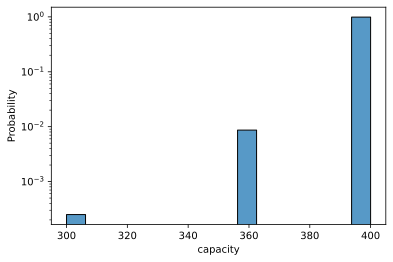

In [ ]:
sns.histplot(data=bwdf2['capacity'], stat='probability')
plt.yscale('log')
